## 实验一：基于前馈神经网络的分类任务设计

### 准备工作

我们使用Pytorch框架，导入所需要的包，并读入数据。然后，我们对数据进行一些预处理，详见代码。

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from torchviz import make_dot


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

df = pd.read_csv('dataset.csv')

# shuffle data
df = df.sample(frac=1).reset_index(drop=True)

X = df[['data1', 'data2']].values
y = df['label'].values

# split trainset and testset
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.1,
                                                    random_state=np.random.RandomState(
                                                        np.random.MT19937(
                                                            np.random.SeedSequence(123456789)
                                                    )))

# standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# convert to tensor
X_train_tensor = torch.Tensor(X_train).to(device)
X_test_tensor = torch.Tensor(X_test).to(device)
y_train_tensor = torch.Tensor(y_train).long().to(device)
y_test_tensor = torch.Tensor(y_test).long().to(device)

# original data is [1, 4], which doesn't match the number of classes, so change it into [0, 3]
y_train_tensor -= 1
y_test_tensor -= 1

Using device: cuda


数据预处理后，我们生成训练数据集。

In [2]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### 定义网络模型

在这里定义一个可改变层数、神经元数和激活函数的神经网络模型。网络结构大致如下：

- 第一层是一个 `(2, num_neurons)` 的全连接层。

- 第一层后面是隐藏层，第 `i` 个隐藏层是一个 `(num_neurons >> (i), num_neurons >> (i + 1))` 的全连接层；换言之，它们的神经元个数会按每次除于2的方式递减。

- 最后一层是输出层，是一个 `(num_neurons >> ((num_layers - 1)), 4)` 的全连接层。

- 每一个全连接层之间还有激活函数。

可以通过在初始化时改变 `num_layers`、`num_neurons` 和 `activation_func` 改变这个模型的结构。

In [3]:
class CustomNet(nn.Module):
    def __init__(self, num_layers, num_neurons, activation_func):
        super(CustomNet, self).__init__()
        layers = [nn.Linear(2, num_neurons), activation_func()]
        for i in range(num_layers - 1):
            print(i)
            layers.append(nn.Linear(num_neurons >> (i),
                                    num_neurons >> ((i + 1))))
            layers.append(activation_func())
        layers.append(nn.Linear(num_neurons >> ((num_layers - 1)), 4))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

### 定义训练和评估函数

训练和评估函数会在某个模型训练的每一轮 epoch 时一并进行评估，并记录该轮次的训练损失、测试损失和测试准确率。

这里采用交叉熵损失函数和 Adam 优化器。

In [4]:
def train_and_evaluate(model, learning_rate, train_loader, epochs):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=1e-4)
    epochs = epochs
    train_losses, test_losses, test_accuracies = [], [], []

    print(model)
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        average_train_loss = total_loss / len(train_loader)
        train_losses.append(average_train_loss)

        model.eval()
        with torch.no_grad():
            outputs = model(X_test_tensor)
            loss = criterion(outputs, y_test_tensor)
            _, predicted = torch.max(outputs, 1)
            accuracy = (
                predicted == y_test_tensor
            ).sum().item() / len(y_test_tensor)
            test_losses.append(loss.item())
            test_accuracies.append(accuracy)

        if (epoch + 1) % 1 == 0:
            print('Epoch {}/{}: Train loss: {:.4f} ' + 
                  '| Test loss: {:.4f} | Test accuracy: {:.4f}%'.format(
                epoch + 1, epochs, 
                train_losses[-1], test_losses[-1],
                test_accuracies[-1] * 100))

    return train_losses, test_losses, test_accuracies

### 对不同配置参数的模型进行评估

采用控制变量法的方式，在给出一个基准配置之后逐项改变模型配置，对每一个配置都训练相应模型，并观察配置的改变对模型的损失和准确率有何影响；在每个模型训练和评估完后，把它的网络结构进行可视化，存放在 `model_visualize` 文件夹中。

这里采用的基准配置是：学习率 0.001，隐藏层数 2，神经元数目（第二层） 64，激活函数 ReLU。

In [5]:
baseline_config = {'lr': 0.001,
                   'num_layers': 2,
                   'num_neurons': 64,
                   'activation': nn.ReLU}


configs_to_explore = {
    'lr': [0.1, 0.01, 0.001], 
    'num_layers': [1, 2, 3],  
    'num_neurons': [32, 64, 96],  
    'activation': [nn.ReLU, nn.PReLU, nn.ELU, nn.LeakyReLU]  
}

def cvt_val_name(val, var_name):
    if var_name != 'activation':
        return val
    
    if val == nn.ReLU:
        return 'ReLU'
    elif val == nn.PReLU:
        return 'PReLU'
    elif val == nn.ELU:
        return 'ELU'
    elif val.__name__ == nn.LeakyReLU.__name__:
        return 'LeakyReLU'
    else:
        return 'Unknown'

results = {'lr':{}, 'num_layers':{}, 'num_neurons':{}, 'activation':{}}
for variable, values in configs_to_explore.items():
    for value in values:
        config = baseline_config.copy()
        config[variable] = value
        print('Evaluating', variable, cvt_val_name(value, variable))
        model = CustomNet(config['num_layers'],
                          config['num_neurons'],
                          config['activation']).to(device)
        train_losses, test_losses, test_accuracies = train_and_evaluate(model,
                                                                        config['lr'],
                                                                        train_loader,
                                                                        100)
        torch.save(model.state_dict(),
                   'models/model_{}_{}.pth'.format(variable,
                                                   cvt_val_name(value, variable)))
        results[variable][cvt_val_name(value, variable)] = (train_losses,
                                                            test_losses,
                                                            test_accuracies)

        # visualize model architecture
        make_dot(model(X_test_tensor),
                 params=dict(model.named_parameters())).render(
            'model_{}_{}'.format(variable, cvt_val_name(value, variable)),
            directory="model_visualize/",
            format="png")

        model.eval()
        with torch.no_grad():
            train_outputs = model(X_train_tensor)
            _, train_predicted = torch.max(train_outputs, 1)
            train_accuracy = (
                train_predicted == y_train_tensor
            ).sum().item()/ len(y_train_tensor)

            test_outputs = model(X_test_tensor)
            _, test_predicted = torch.max(test_outputs, 1)
            test_accuracy = (
                test_predicted == y_test_tensor
            ).sum().item() / len(y_test_tensor)

        print(f"Final Train Accuracy: {train_accuracy:.4f}")
        print(f"Final Test Accuracy: {test_accuracy:.4f}")
        


Evaluating lr 0.1
0
CustomNet(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)
Epoch 1/100: Train loss: 0.3720 | Test loss: 0.2709 | Test accuracy: 91.2500%
Epoch 2/100: Train loss: 0.2913 | Test loss: 0.3136 | Test accuracy: 89.2500%
Epoch 3/100: Train loss: 0.2717 | Test loss: 0.2123 | Test accuracy: 93.7500%
Epoch 4/100: Train loss: 0.2712 | Test loss: 0.2915 | Test accuracy: 89.2500%
Epoch 5/100: Train loss: 0.2746 | Test loss: 0.2969 | Test accuracy: 89.7500%
Epoch 6/100: Train loss: 0.2660 | Test loss: 0.2012 | Test accuracy: 94.5000%
Epoch 7/100: Train loss: 0.2650 | Test loss: 0.2400 | Test accuracy: 91.0000%
Epoch 8/100: Train loss: 0.2620 | Test loss: 0.2882 | Test accuracy: 90.7500%
Epoch 9/100: Train loss: 0.2789 | Test loss: 0.2117 | Test accuracy: 93.2500%
Epoch 10/100: Train loss: 0

### 可视化

按照控制变量的方式，把只改变某一项的所有模型 loss 和 accuracy 一同画在一张图中。

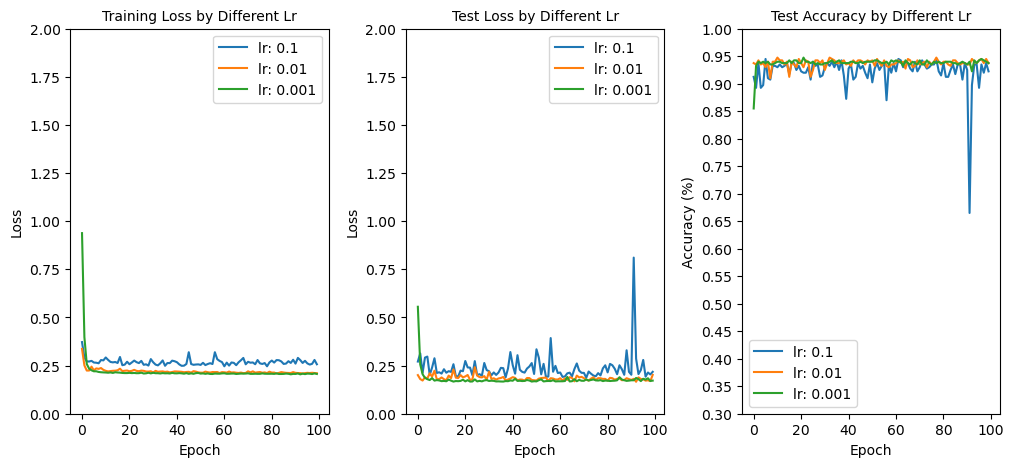

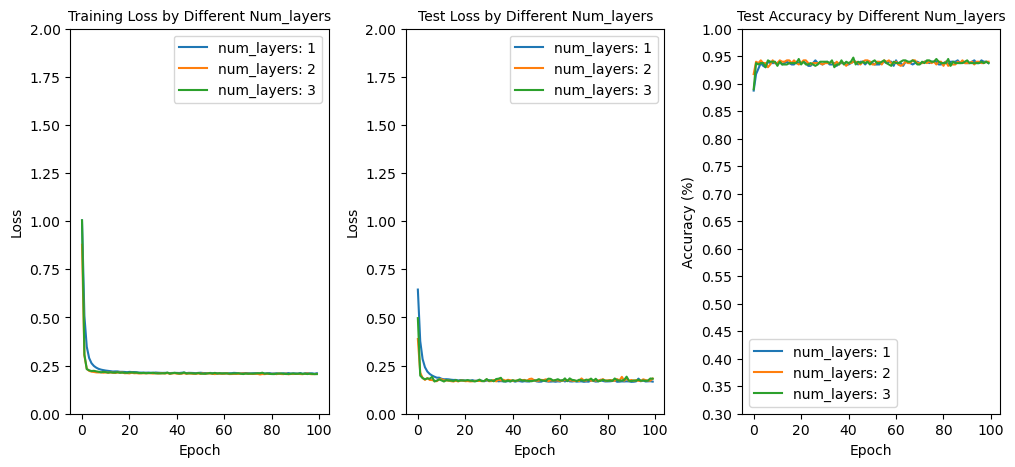

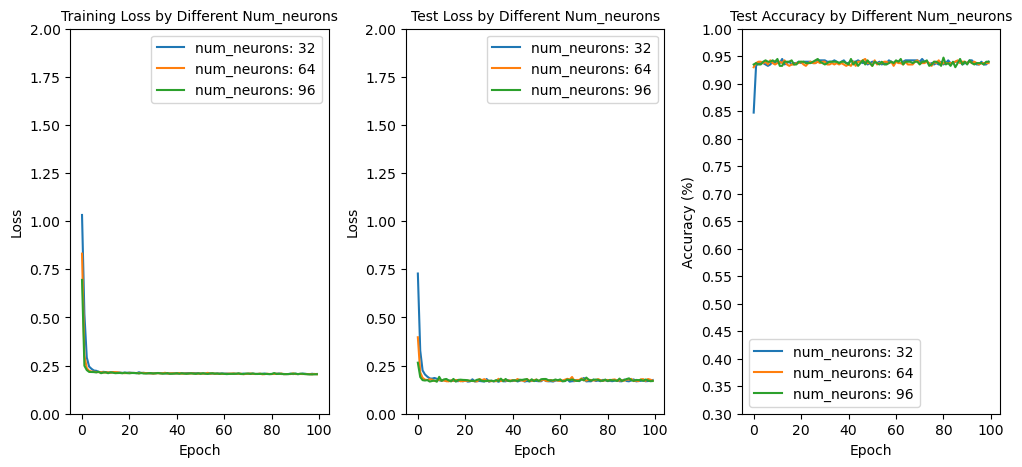

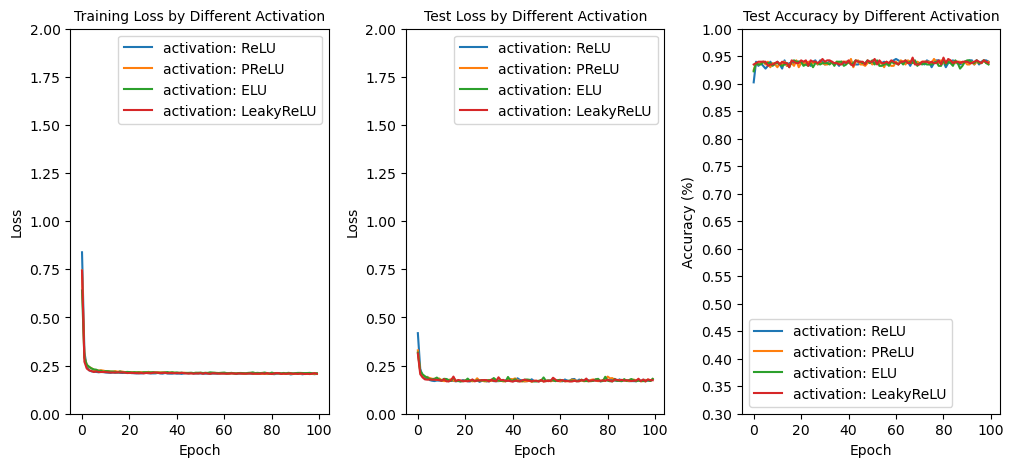

In [10]:
for variable, configs in results.items():
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.subplots_adjust(wspace=0.3)
    for value, (train_losses, _, _) in configs.items():
        plt.plot(train_losses, label=f'{variable}: {value}')
    plt.title(f"Training Loss by Different {variable.capitalize()}",
              fontdict={'fontsize': 10})
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0, 2)
    plt.yticks(np.arange(0, 2.1, 0.25))
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.subplots_adjust(wspace=0.3)
    for value, (_, test_losses, _) in configs.items():
        plt.plot(test_losses, label=f'{variable}: {value}')
    plt.title(f"Test Loss by Different {variable.capitalize()}",
              fontdict={'fontsize': 10})
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0, 2)
    plt.yticks(np.arange(0, 2.1, 0.25))
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.subplots_adjust(wspace=0.3)
    for value, (_, _, test_accuracies) in configs.items():
        plt.plot(test_accuracies, label=f'{variable}: {value}')
    plt.title(f"Test Accuracy by Different {variable.capitalize()}",
              fontdict={'fontsize': 10})
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.ylim(0.3, 1)
    plt.yticks(np.arange(0.3, 1.05, 0.05))
    plt.legend()

    plt.show()

### 结果分析

总体来看，各配置下神经网络对于该数据集都能很快收敛，而后 loss 和 accuracy 稳定在一个水平，这可能是因为各个模型对于该任务来说都比较大。

##### 学习率

```
Evaluating lr 0.1
Final Train Accuracy: 0.9192
Final Test Accuracy: 0.9225

Evaluating lr 0.01
Final Train Accuracy: 0.9225
Final Test Accuracy: 0.9375

Evaluating lr 0.001
Final Train Accuracy: 0.9283
Final Test Accuracy: 0.9375
```

本次实验采用了 0.1、0.01 和 0.001三种学习率，观察上图我们可以发现 0.1 学习率下，模型的 loss 和 accuracy 均有较大波动，而另外两种都较为稳定。

##### 网络层数

```
Evaluating num_layers 1
CustomNet(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=4, bias=True)
  )
)
Final Train Accuracy: 0.9258
Final Test Accuracy: 0.9375

Evaluating num_layers 2
CustomNet(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)
Final Train Accuracy: 0.9272
Final Test Accuracy: 0.9400

Evaluating num_layers 3
CustomNet(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=4, bias=True)
  )
)
Final Train Accuracy: 0.9283
Final Test Accuracy: 0.9375
```

本次实验采用了 1~3 层隐藏层的配置。由图表可知，三种配置均能使模型很快收敛，但是 1 层隐藏层的较另外两种要慢； 2、3 层下模型表现相差不大。这说明对于本次实验的简单分类任务，在其他参数相同的情况下，隐藏层越多，网络性能越好；但是，提升层数的收益也是递减的。同时，此次数据量较小，增加层数也出现了过拟合的现象。

##### 神经元个数

```
Evaluating num_neurons 32
CustomNet(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=4, bias=True)
  )
)
Final Train Accuracy: 0.9300
Final Test Accuracy: 0.9400

Evaluating num_neurons 64
CustomNet(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)
Final Train Accuracy: 0.9269
Final Test Accuracy: 0.9375

Evaluating num_neurons 96
CustomNet(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=96, bias=True)
    (1): ReLU()
    (2): Linear(in_features=96, out_features=48, bias=True)
    (3): ReLU()
    (4): Linear(in_features=48, out_features=4, bias=True)
  )
)
Final Train Accuracy: 0.9272
Final Test Accuracy: 0.9400
```

本次实验采用了 32、64、96 三种神经元个数的配置。由图表可知，对于本次实验的任务，神经元个数越多，网络性能越好；同网络层数一样，增加神经元个数的收益也是递减的。

##### 激活函数

```
Evaluating activation ReLU
Final Train Accuracy: 0.9286
Final Test Accuracy: 0.9400

Evaluating activation PReLU
Final Train Accuracy: 0.9253
Final Test Accuracy: 0.9400

Evaluating activation ELU
Final Train Accuracy: 0.9281
Final Test Accuracy: 0.9350

Evaluating activation LeakyReLU
Final Train Accuracy: 0.9286
Final Test Accuracy: 0.9375
```

本次实验采用了 ReLU、PReLU、ELU、LeakyReLU 四种激活函数。由图表可知，各激活函数的性能非常相近；原始的 ReLU 收敛最慢。